In [1]:
!pip install -Uqq fastbook

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 46 kB 3.7 MB/s 
     |████████████████████████████████| 1.2 MB 33.0 MB/s 
     |████████████████████████████████| 189 kB 47.6 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 51 kB 214 kB/s 


In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.all import *

In [3]:
URLs.CAMVID

'https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz'

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [5]:
path=Path(base_dir + "models/labeler")

In [6]:
codes = {'title1': 0, 'title2': 1, 'title3': 2, 'title4': 3, 'header': 4, 'footer': 5, 'signature': 6, 'text': 7, 'nontext': 8, 'void': 9}
codesItems = array(list(codes.keys()))
codesItems

array(['title1', 'title2', 'title3', 'title4', 'header', 'footer', 'signature', 'text', 'nontext', 'void'], dtype='<U9')

In [ ]:
pp = ['title1',
 'title2',
 'title3',
 'title4',
 'header',
 'footer',
 'signature',
 'text',
 'nontext',
 'void']
len(pp)

10

In [ ]:
while(len(pp) < 255):
  pp.append('void')
pp

In [ ]:
codesItems = array(pp)

In [7]:
def get_msk(o):
  return path/'labeled_data'/f'{o.stem}{o.suffix}'

In [8]:
fnames = get_image_files(path/'data')

In [9]:
a = get_msk(fnames[10])

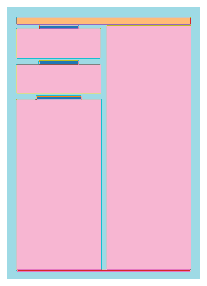

In [10]:
msk = PILMask.create(get_msk(fnames[8]))
msk.show(figsize=(5,5), alpha=1)

In [11]:
fnames[8]

Path('/content/gdrive/My Drive/fastai-v3/models/labeler/data/ckug5v3jv18ki0y3sdnbn8fim.png')

In [12]:
tensor(msk)

tensor([[9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        ...,
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9]], dtype=torch.uint8)

In [13]:
labeler = DataBlock(
    blocks=(ImageBlock, MaskBlock(codesItems)),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=24),
    get_y=get_msk,
    item_tfms=Resize(256, ResizeMethod.Pad, pad_mode='zeros'),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

In [14]:
dls = labeler.dataloaders(path/'data', bs=8)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


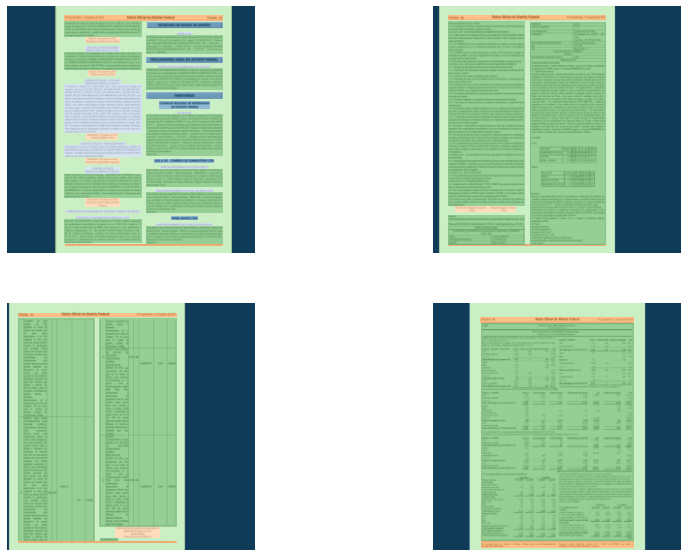

In [15]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [16]:
dls.vocab = codesItems

In [17]:
void_code = codes['void']

In [18]:
def acc_labeler(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [19]:
learn = unet_learner(dls, resnet18, metrics=acc_labeler, self_attention=True, act_cls=Mish, opt_func=ranger)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=9.120108734350652e-05)

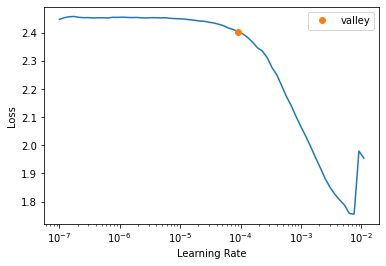

In [20]:
learn.lr_find()

In [22]:
lr = 1e-4

In [23]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_labeler,time
0,2.456786,2.375303,0.010790,00:10
1,2.454434,2.367527,0.011121,00:06
2,2.437037,2.324032,0.015822,00:06
3,2.400274,2.314624,0.024927,00:06
4,2.372124,2.257726,0.128817,00:06
5,2.323937,2.244547,0.172055,00:06
6,2.284139,2.176200,0.429231,00:05
7,2.217338,2.135864,0.526298,00:06
8,2.160779,1.997830,0.648334,00:05
9,2.092405,2.020620,0.621783,00:05


In [24]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [25]:
learn.load('stage-1')

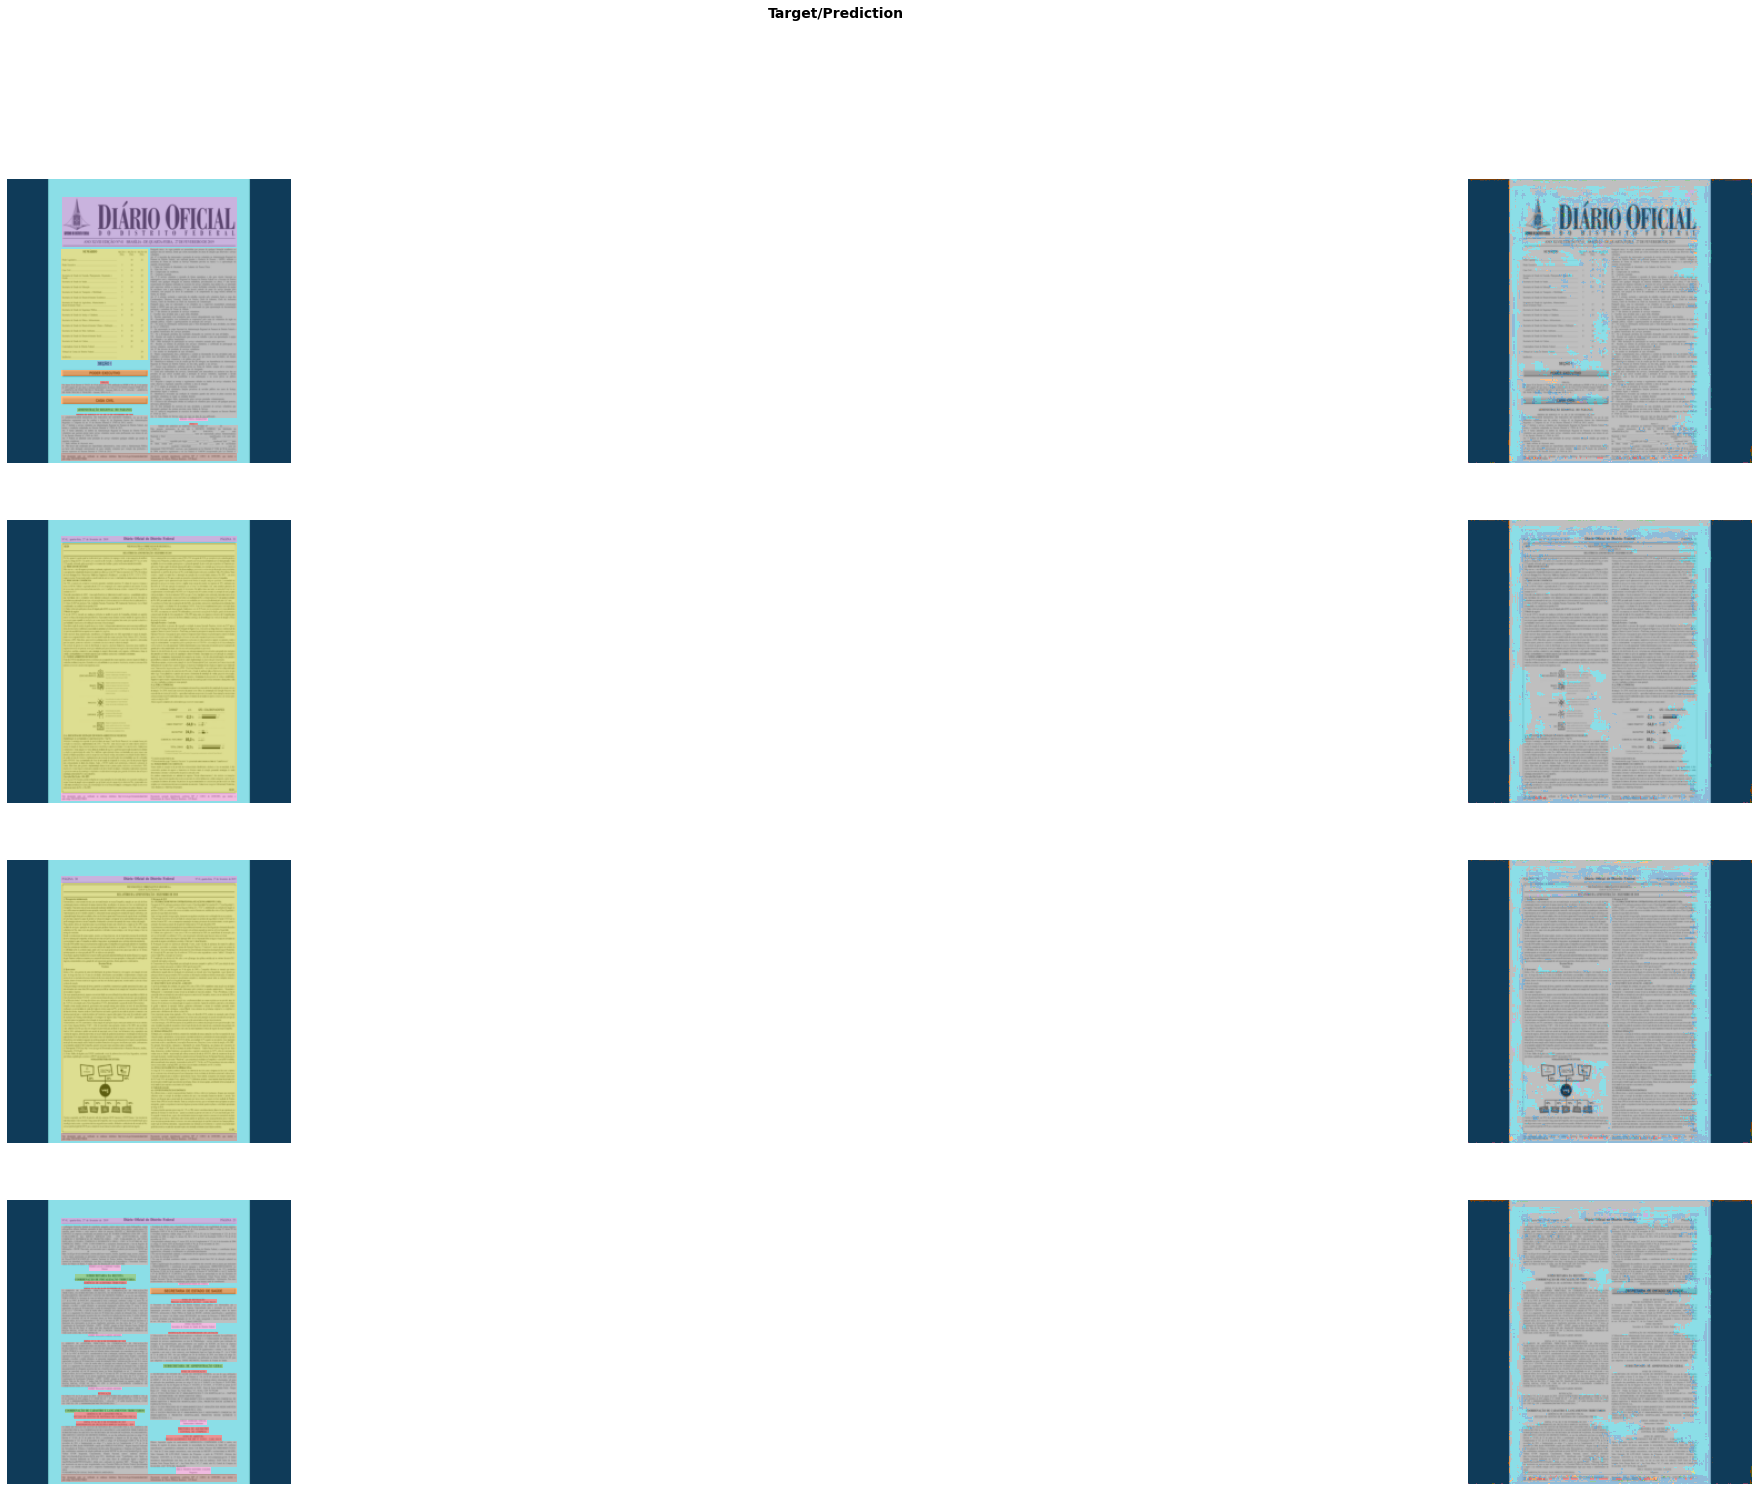

In [33]:
learn.show_results(max_n=4, figsize=(48,24))

In [28]:
lrs = slice(lr/400, lr/4)

In [29]:
learn.unfreeze()

In [30]:
learn.fit_flat_cos(12, lrs)

epoch,train_loss,valid_loss,acc_labeler,time
0,1.730718,1.999681,0.621246,00:06
1,1.731381,1.981698,0.621306,00:06
2,1.733629,1.943838,0.631827,00:06
3,1.725498,1.926482,0.632346,00:06
4,1.715801,1.868391,0.644215,00:06
5,1.685660,1.848995,0.644332,00:06
6,1.669500,1.778146,0.657786,00:06
7,1.648059,1.744380,0.656863,00:06
8,1.633839,1.642496,0.662968,00:06
9,1.606986,1.614455,0.662103,00:06


In [31]:
learn.save('model_1')

Path('models/model_1.pth')

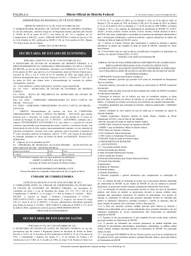

In [34]:
imgURL = 'https://i.imgur.com/RyWKpr3.png'
img = requests.get(imgURL, allow_redirects=True).content

test_image = PILImage.create(img)
test_image.to_thumb(256)

In [36]:
preci = learn.predict(test_image)

In [46]:
preci[0].shape

torch.Size([256, 256])

In [47]:
whatever = preci[0].argmax(dim=0)

In [49]:
whatever

TensorMask([255,   0,   0,   0,   0,   0,   0, 255,   0,   0,   0,   1,   0,   1,   0,   0,   0,   0,   1,   1,   1,   0,   1,   1,   0,   0,   0,   0,   1,   0,   0,   0, 212, 129,   7,   0,   0,   0,
          0,   0,   2,   2,   2,   5,   5,   6,   4,   6,   2,   3,   4,   4,   5,   5,   6,   6,   6,   6,   6,   6,   2,   2,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   8,   6,   6,
          8,   6,   6,   6,   7,   8,   8,   8,   8,   8,   6,   6,   7,  51,   8,   8,   8, 175,  16,  49,   6,   6,   6,  49,  49,   3,   2,   2,   2,   2,   6,  49,  49,  49,   8,  21,   1,   9,
         13,   8,   6,   6,   6,   6,   8,   6,   6,   6,   6,   8,   8,   8,   6,   9,   6,   6, 223,   6,   6,   7,   2,   2,   6,   7,   8,   8,   8,   8,   8,   2,   2,   8,   2,   2,   2,   2,
          6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   2,   1,   1,   6,
      

In [57]:
preci[2][0].shape

torch.Size([256, 256])

In [ ]:
plt.imshow(preci[2][0])